# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [2]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [12]:
for i_episode in range(1):
    state = env.reset()
    while True:
        print(f'state: {state}')
        action = env.action_space.sample()
        print(f'action{action}')
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

state: (21, 2, True)
action0
End game! Reward:  0.0
You lost :(



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [3]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [4]:
for i in range(1):
    episode = generate_episode_from_limit_stochastic(env)
    #print(*episode)
    states, actions, rewards = zip(*episode)
    print(states)
    print(actions)
    print(rewards)
    #print(generate_episode_from_limit_stochastic(env))

((14, 10, False),)
(1,)
(-1,)


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [26]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    # we will record cumulative records for all state, action pairs
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # N will record number of visits to each state
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Q table where we record average values for each state-action (returns/N)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        # generate episode using a function
        episode = generate_episode(env)
        
        # episode returns a tuple of tuples
        # one episode (game) is many state-action pairs [HIT, STICK]
        states, actions, rewards = zip(*episode)
        
        #discount array
        gammas = np.array([gamma**i for i in range(len(rewards) + 1)])
        
        # we update Q table for all state-actions pairs with corresponding reward
        for i, state in enumerate(states):
            # accumulate all rewards
            returns_sum[state][actions[i]] += sum(rewards[i:] * gammas[:-(1+i)])
            # divide by visits to get average value
            N[state][actions[i]] += 1.0 #use float because we divide by this
            # update Q value with new value
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
        
    return Q

In [1]:
states = [4,2,3]
rewards = [2,2,2]
discounts = np.array([.9**i for i in range(len(states) +1)])
print(discounts)
for i in range(len(states)):
    print(sum(rewards[i:] * discounts[:-(1+i)]))



NameError: name 'np' is not defined

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 50000/50000.

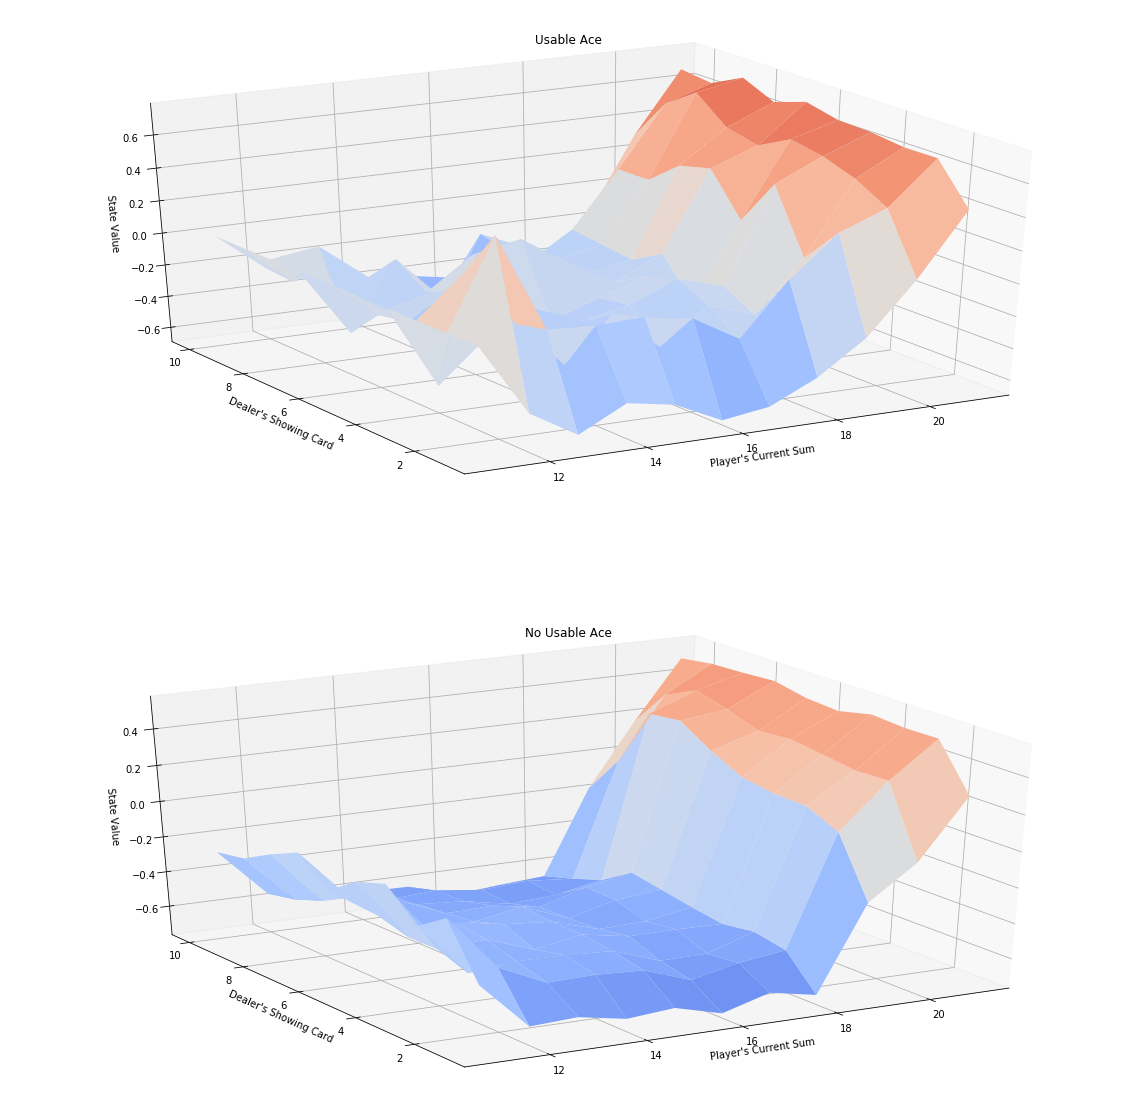

In [29]:
# obtain the action-value function
Q = mc_prediction_q(env, 50000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [51]:

def generate_episode(env, nA, Q, epsilon):
    # create empty episode
    episode = []
    
    # reset env
    state = env.reset()
    
    # we are not done, just starting
    done = False
    
    # play game until termination
    while not done:
        
        # choose action. explore or exploit, based on epsilon value
        if state in Q and np.random.random() > epsilon:       
            # If we have observation for the state, oportunity to exploit
            action = np.argmax(Q[state])
        else: 
            # explore otherwise
            action = np.random.randint(nA)
            
        # take the action
        next_state, reward, done, info = env.step(action)
        
        # record S, A, R for (S, A)
        episode.append((state, action, reward))
        state = next_state

    return episode


def generate_discounts(i, gamma):
    return np.array([gamma ** i for i in range(i + 1)])


def update_q_table(env, Q, episode, alpha, discounts):
    # updates "every visit"
    states, actions, rewards = zip(*episode)
    for i in range(len(states)):
        # Calculate updated Q value
        new_Q = Q[states[i]][actions[i]] + alpha * sum(rewards[i:]* discounts[:-(1+i)])
        # Update Q table with new value
        Q[states[i]][actions[i]] = new_Q
    return Q

In [44]:
def mc_control(env, num_episodes, alpha, gamma=1.0, epsilon=1.0, eps_decay=0.99999, min_eps=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}. Epsilon:{epsilon}","")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        episode = generate_episode(env, nA, Q, epsilon)
        
        # calculate new epsilon value
        epsilon = max(epsilon*eps_decay, min_eps)
        
        # calculate discounts
        discounts = generate_discounts(len(episode), gamma)
        
        # update Q value using epsilon and discounts
        Q = update_q_table(env, Q, episode, alpha, discounts)
        Q2 = update_q_table2(env, Q, episode, alpha, discounts)
    

    return Q, Q2

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [45]:
# obtain the estimated optimal policy and action-value function
Q, Q2 = mc_control(env, num_episodes=500000, alpha=0.02)
policy = dict((k, np.argmax(v)) for k, v in Q.items())

Episode 1000/500000. Epsilon:0.9900596848432421 
Episode 2000/500000. Epsilon:0.9802083773701007 
Episode 3000/500000. Epsilon:0.9704550925317743 
Episode 4000/500000. Epsilon:0.960798854981895 
Episode 5000/500000. Epsilon:0.9512386990790049 
Episode 6000/500000. Epsilon:0.9417736687899882 
Episode 7000/500000. Epsilon:0.9324028175944599 
Episode 8000/500000. Epsilon:0.923125208390123 
Episode 9000/500000. Epsilon:0.9139399133990471 
Episode 10000/500000. Epsilon:0.9048460140748944 
Episode 11000/500000. Epsilon:0.8958426010110587 
Episode 12000/500000. Epsilon:0.8869287738497265 
Episode 13000/500000. Epsilon:0.8781036411918409 
Episode 14000/500000. Epsilon:0.8693663205079526 
Episode 15000/500000. Epsilon:0.8607159380499775 
Episode 16000/500000. Epsilon:0.8521516287638128 
Episode 17000/500000. Epsilon:0.8436725362028248 
Episode 18000/500000. Epsilon:0.8352778124422134 
Episode 19000/500000. Epsilon:0.8269666179942117 
Episode 20000/500000. Epsilon:0.8187381217241406 
Episode 210

Next, we plot the corresponding state-value function.

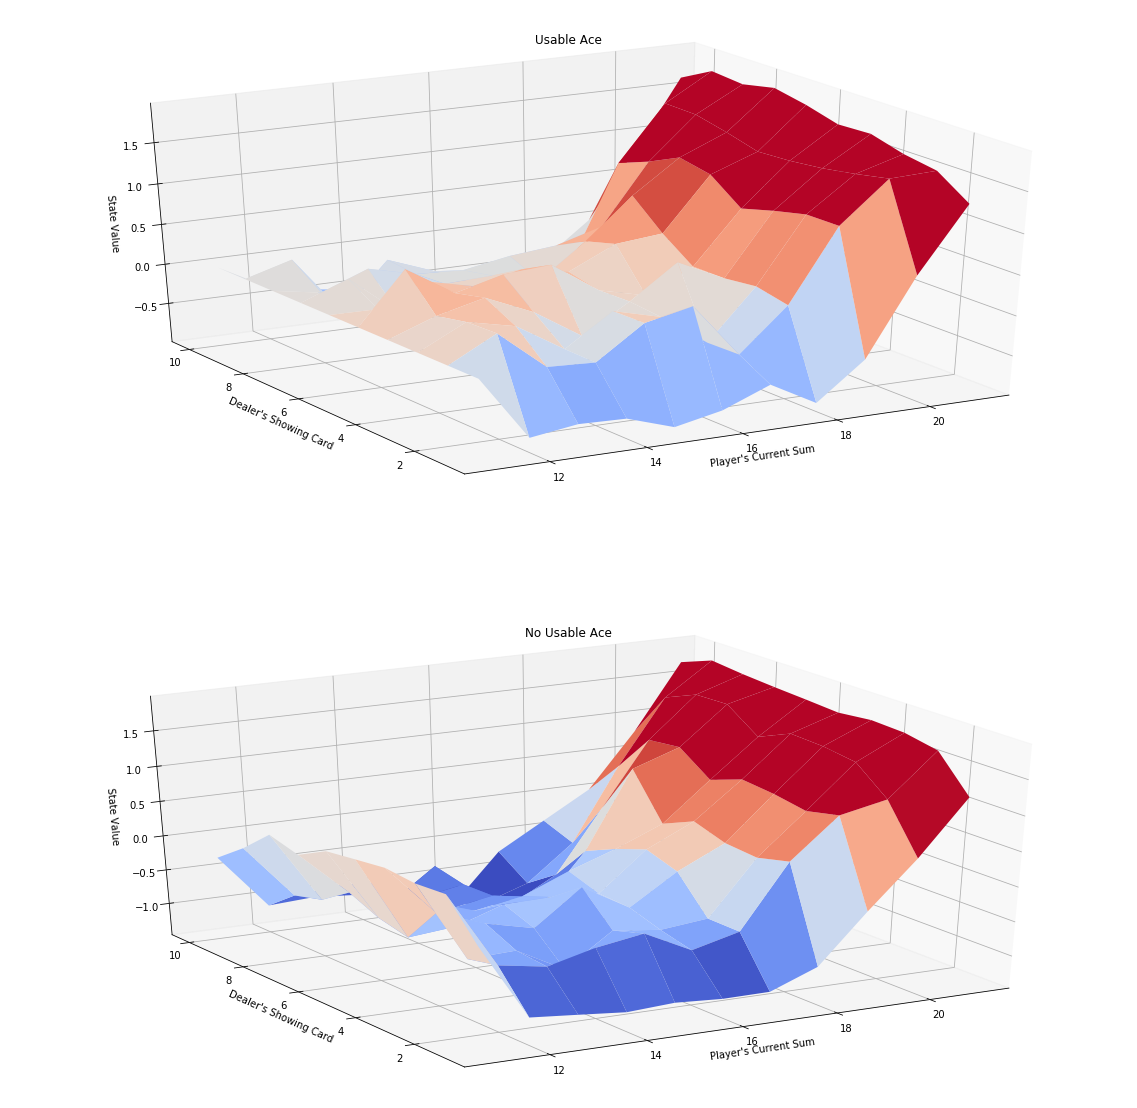

In [46]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

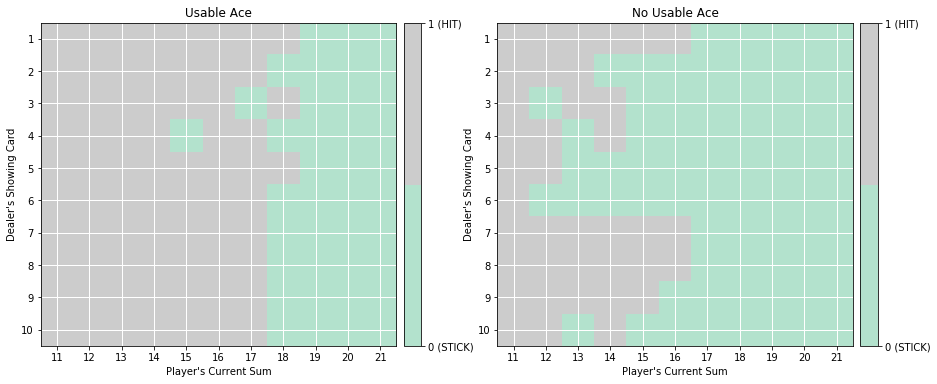

In [47]:
# plot the policy
plot_policy(policy)

In [50]:
i = 0
for k, v in Q.items():
    print(k, v)
    print(Q2[k])
    i=i+1
    if i >5:
        break

(14, 6, False) [-0.6272418  -0.70854277]
[-0.6272418  -0.70854277]
(7, 10, False) [-1.38852022 -1.09447148]
[-1.38852022 -1.09447148]
(13, 10, False) [-1.03495696 -1.37289326]
[-1.03495696 -1.37289326]
(14, 10, False) [-1.35861858 -1.0927732 ]
[-1.35861858 -1.0927732 ]
(5, 1, False) [-1.45592846 -0.88090486]
[-1.45592846 -0.88090486]
(15, 1, False) [-1.52094142 -1.14972375]
[-1.52094142 -1.14972375]


The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)